# **Load ChEMBL data**

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('raw_CHEMBL203_EGFR.csv',sep=";")
print(df.shape)
df.head(3)

(14362, 45)


,Molecule ChEMBL ID,Molecule Name,Molecule Max Phase,Molecular Weight,#RO5 Violations,AlogP,Compound Key,Smiles,Standard Type,Standard Relation,Standard Value,Standard Units,pChEMBL Value,Data Validity Comment,Comment,Uo Units,Ligand Efficiency BEI,Ligand Efficiency LE,Ligand Efficiency LLE,Ligand Efficiency SEI,Potential Duplicate,Assay ChEMBL ID,Assay Description,Assay Type,BAO Format ID,BAO Label,Assay Organism,Assay Tissue ChEMBL ID,Assay Tissue Name,Assay Cell Type,Assay Subcellular Fraction,Assay Parameters,Assay Variant Accession,Assay Variant Mutation,Target ChEMBL ID,Target Name,Target Organism,Target Type,Document ChEMBL ID,Source ID,Source Description,Document Journal,Document Year,Cell ChEMBL ID,Properties
0,CHEMBL4465103,NaN,0,537.61,1,4.34,7e,C=CC(=O)Nc1cc(Nc2nccc(Nc3ccccc3P(C)(C)=O)n2)c(...,IC50,'=',149.00,nM,6.83,NaN,NaN,UO_0000065,12.70,0.25,2.49,6.11,False,CHEMBL4382298,Inhibition of wild type GST-tagged human EGFR ...,B,BAO_0000019,assay format,Homo sapiens,None,None,None,None,NaN,NaN,NaN,CHEMBL203,Epidermal growth factor receptor erbB1,Homo sapiens,SINGLE PROTEIN,CHEMBL4382192,1,Scientific Literature,Eur J Med Chem,2017.0,None,NaN
1,CHEMBL3355875,NaN,0,486.89,1,5.14,15c,COc1cc2ncnc(Nc3ccc(F)c(Cl)c3)c2cc1OCCCCn1ccnc1...,IC50,'=',0.47,nM,9.33,NaN,NaN,UO_0000065,19.16,0.37,4.19,7.96,False,CHEMBL3372999,Inhibition of wild type EGFR (unknown origin) ...,B,BAO_0000357,single protein format,Homo sapiens,None,None,None,None,NaN,NaN,NaN,CHEMBL203,Epidermal growth factor receptor erbB1,Homo sapiens,SINGLE PROTEIN,CHEMBL3351739,1,Scientific Literature,Eur. J. Med. Chem.,2015.0,None,NaN
2,CHEMBL4224812,NaN,0,516.61,1,3.77,8,C=CC(=O)Nc1cccc(NC(=O)N(C)c2ccnc(Nc3ccc(N4CCN(...,IC50,'>',1000.00,nM,NaN,NaN,NaN,UO_0000065,NaN,NaN,NaN,NaN,False,CHEMBL4222198,Inhibition of recombinant human GST-tagged wil...,B,BAO_0000019,assay format,Homo sapiens,None,None,None,None,NaN,NaN,NaN,CHEMBL203,Epidermal growth factor receptor erbB1,Homo sapiens,SINGLE PROTEIN,CHEMBL4219138,1,Scientific Literature,Bioorg Med Chem Lett,2018.0,None,NaN


In [3]:
#print(df.columns)

## **Filter data by standard units**

In [4]:
# Check if the data only has target_organism=='Homo sapiens'
print(pd.unique(df['Target Organism']))
# Filter data by target_organism=='Homo sapiens'
df=df[df['Target Organism'].isin(['Homo sapiens'])]
print(pd.unique(df['Target Organism']))
print(df.shape)

# Check if the data only has standard_type=='IC50'
print(pd.unique(df['Standard Type']))

print(pd.unique(df['Standard Units']))
# Filter data by units = ['nM','ug.mL-1','uM','pM','ug/g']
units = ['nM','ug.mL-1','uM','pM','ug/g']
df=df[df['Standard Units'].isin(units)].reset_index().drop(columns='index')

print(pd.unique(df['Standard Units']))
print(df.shape)

['Homo sapiens']
['Homo sapiens']
(14362, 45)
['IC50']
['nM' nan 'ug.mL-1' '/uM']
['nM' 'ug.mL-1']
(13029, 45)


# **Data Cleaning**


* Drop missing SMILE notation
* Drop missing standard values
* Drop duplicated assays (by assay ID)


In [5]:
# Drop compounds having missing standard_value.
df2 = df[df['Standard Value'].notna()]
print(df2.shape)

# Drop compounds having missing canonical_smiles column.
df2 = df2[df['Smiles'].notna()]
print(df2.shape)

# Reset index
df2 = df2.reset_index().drop(columns='index')
print(df2.shape)
df2.head(3)

(13029, 45)
(13022, 45)
(13022, 45)


,Molecule ChEMBL ID,Molecule Name,Molecule Max Phase,Molecular Weight,#RO5 Violations,AlogP,Compound Key,Smiles,Standard Type,Standard Relation,Standard Value,Standard Units,pChEMBL Value,Data Validity Comment,Comment,Uo Units,Ligand Efficiency BEI,Ligand Efficiency LE,Ligand Efficiency LLE,Ligand Efficiency SEI,Potential Duplicate,Assay ChEMBL ID,Assay Description,Assay Type,BAO Format ID,BAO Label,Assay Organism,Assay Tissue ChEMBL ID,Assay Tissue Name,Assay Cell Type,Assay Subcellular Fraction,Assay Parameters,Assay Variant Accession,Assay Variant Mutation,Target ChEMBL ID,Target Name,Target Organism,Target Type,Document ChEMBL ID,Source ID,Source Description,Document Journal,Document Year,Cell ChEMBL ID,Properties
0,CHEMBL4465103,NaN,0,537.61,1,4.34,7e,C=CC(=O)Nc1cc(Nc2nccc(Nc3ccccc3P(C)(C)=O)n2)c(...,IC50,'=',149.00,nM,6.83,NaN,NaN,UO_0000065,12.70,0.25,2.49,6.11,False,CHEMBL4382298,Inhibition of wild type GST-tagged human EGFR ...,B,BAO_0000019,assay format,Homo sapiens,None,None,None,None,NaN,NaN,NaN,CHEMBL203,Epidermal growth factor receptor erbB1,Homo sapiens,SINGLE PROTEIN,CHEMBL4382192,1,Scientific Literature,Eur J Med Chem,2017.0,None,NaN
1,CHEMBL3355875,NaN,0,486.89,1,5.14,15c,COc1cc2ncnc(Nc3ccc(F)c(Cl)c3)c2cc1OCCCCn1ccnc1...,IC50,'=',0.47,nM,9.33,NaN,NaN,UO_0000065,19.16,0.37,4.19,7.96,False,CHEMBL3372999,Inhibition of wild type EGFR (unknown origin) ...,B,BAO_0000357,single protein format,Homo sapiens,None,None,None,None,NaN,NaN,NaN,CHEMBL203,Epidermal growth factor receptor erbB1,Homo sapiens,SINGLE PROTEIN,CHEMBL3351739,1,Scientific Literature,Eur. J. Med. Chem.,2015.0,None,NaN
2,CHEMBL4224812,NaN,0,516.61,1,3.77,8,C=CC(=O)Nc1cccc(NC(=O)N(C)c2ccnc(Nc3ccc(N4CCN(...,IC50,'>',1000.00,nM,NaN,NaN,NaN,UO_0000065,NaN,NaN,NaN,NaN,False,CHEMBL4222198,Inhibition of recombinant human GST-tagged wil...,B,BAO_0000019,assay format,Homo sapiens,None,None,None,None,NaN,NaN,NaN,CHEMBL203,Epidermal growth factor receptor erbB1,Homo sapiens,SINGLE PROTEIN,CHEMBL4219138,1,Scientific Literature,Bioorg Med Chem Lett,2018.0,None,NaN


## **Convert Standard Units**

In [6]:
#df['Molecular Weight']

In [7]:
df2 = df2.sort_values('Standard Value').reset_index().drop(columns='index')
df2[['Standard Units','Standard Value','Molecular Weight']].tail(5)

,Standard Units,Standard Value,Molecular Weight
13017,nM,10590098.51,509.97
13018,nM,11000000.00,577.05
13019,nM,13567505.30,495.94
13020,nM,19000000.00,450.40
13021,nM,25000000.00,274.27


In [8]:
#units = ['nM','ug.mL-1','uM','pM','ug/g']

standard_unit_nM = []

for i,j,k in zip(df2['Standard Units'],df2['Standard Value'],df2['Molecular Weight']):
    if i == 'nM':
      standard_unit_nM.append(float(j))
    elif i == 'ug.mL-1':
      standard_unit_nM.append(float(1000000*float(j)/float(k)))
    elif i == 'uM':
      standard_unit_nM.append(float(1000*float(j)))
    elif i == 'pM':
      standard_unit_nM.append(float(float(j)/1000))
    elif i == 'ug/g':
      standard_unit_nM.append(float(1000000*float(j)/float(k)))



In [10]:
#standard_unit_nM
standard_value_nM = pd.Series(standard_unit_nM, name='standard_value_nM')
print(standard_value_nM.shape)
standard_value_nM.tail(3)

(13022,)


13019    13567505.3
13020    19000000.0
13021    25000000.0
Name: standard_value_nM, dtype: float64

In [11]:
df3 = pd.concat([df2, standard_value_nM], axis=1)
#df3.columns
#df3[['Standard Value','Standard Units','standard_unit_nM']]

print(standard_value_nM.shape)
print(df2.shape)
print(df3.shape)

# Sort data by ascending 'standard_unit_nM' values.
df3 = df3.sort_values('standard_value_nM',ascending=True).reset_index().drop(columns='index')
df3[['Standard Value','Standard Units','standard_value_nM', 'Molecular Weight']].loc[(df3['Standard Units']=='ug.mL-1')].tail(3)

(13022,)
(13022, 45)
(13022, 46)


,Standard Value,Standard Units,standard_value_nM,Molecular Weight
12924,200.0,ug.mL-1,557911.180540,358.48
12925,200.0,ug.mL-1,557911.180540,358.48
12934,100.0,ug.mL-1,612820.198554,163.18


## **Duplicated Compounds**

In [13]:
# Keep the one with minimum standard_value for duplicated ['compound_ID','target_ID']
df3 = df3.drop_duplicates(subset=['Molecule ChEMBL ID','Target ChEMBL ID'], keep='first').reset_index().drop(columns='index')
print(df3.shape)
df3['standard_value_nM']

(8537, 46)


0       3.000000e-03
1       6.000000e-03
2       6.000000e-03
3       8.000000e-03
4       8.000000e-03
            ...     
8532    3.000000e+06
8533    5.000000e+06
8534    6.500000e+06
8535    1.900000e+07
8536    2.500000e+07
Name: standard_value_nM, Length: 8537, dtype: float64

In [14]:
# Data pre-processing
# Combine columns (molecule_chembl_id,canonical_smiles,standard_value) and bioactivity_class into a DataFrame
selection = ['Molecule ChEMBL ID','Smiles','standard_value_nM']
df4 = df3[selection].rename(columns={'Molecule ChEMBL ID':'molecule_chembl_id','Smiles':'canonical_smiles','standard_unit_nM':'standard_value'})
print(df4.shape)
df4.tail(3)

(8537, 3)


,molecule_chembl_id,canonical_smiles,standard_value_nM
8534,CHEMBL76587,N#CC(C#N)Cc1ccc(O)cc1,6500000.0
8535,CHEMBL490510,O=C(/C=C/c1ccc(O)c(O)c1)c1ccc(O[C@@H]2O[C@H](C...,19000000.0
8536,CHEMBL45068,O=C(CCc1ccc(O)cc1)c1c(O)cc(O)cc1O,25000000.0


In [15]:
# Saves to CSV 
df4.to_csv('CHEMBL203_bioactivity_data_preprocessed.csv', index=False)

# **Labeling** 

In [16]:
import pandas as pd

df5 = pd.read_csv('CHEMBL203_bioactivity_data_preprocessed.csv')
df5.tail(3)

,molecule_chembl_id,canonical_smiles,standard_value_nM
8534,CHEMBL76587,N#CC(C#N)Cc1ccc(O)cc1,6500000.0
8535,CHEMBL490510,O=C(/C=C/c1ccc(O)c(O)c1)c1ccc(O[C@@H]2O[C@H](C...,19000000.0
8536,CHEMBL45068,O=C(CCc1ccc(O)cc1)c1c(O)cc(O)cc1O,25000000.0


### Distribution


In [17]:
import seaborn as sns
import numpy as np
sns.set(style='ticks')
import matplotlib.pyplot as plt

In [18]:
#df5.standard_value_nM.describe()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


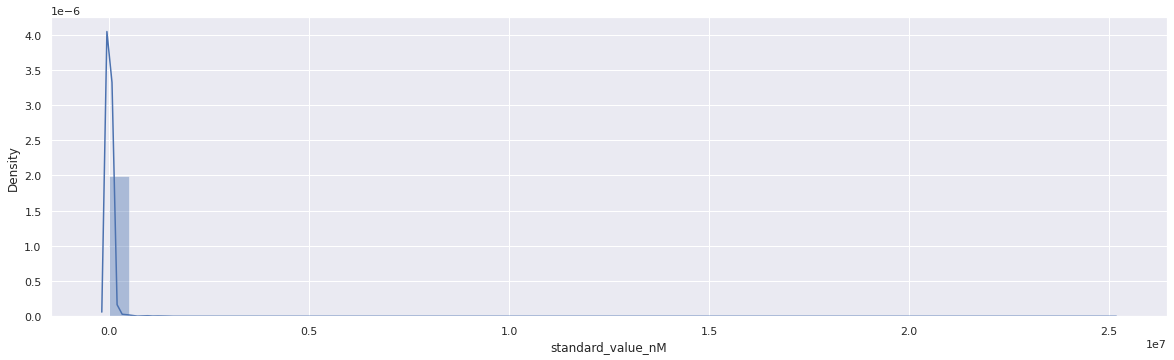

In [19]:
plt.figure(figsize=(20,5.5))
sns.set_theme(); 
ax = sns.distplot(df5['standard_value_nM'])

### Scaling (pIC50)


To allow **IC50** data to be more uniformly distributed, we will convert **IC50** to the negative logarithmic scale which is essentially **-log10(IC50)**.

This custom function pIC50() will accept a DataFrame as input and will:
* Take the IC50 values from the ``standard_value`` column and converts it from nM to M by multiplying the value by 10$^{-9}$
* Take the molar value and apply -log10
* Delete the ``standard_value`` column and create a new ``pIC50`` column

In [20]:
import numpy as np

def pIC50(input):
    pIC50 = []

    for i in input['standard_value_norm']:
        molar = i*(10**-9) # Converts nM to M
        pIC50.append(-np.log10(molar))

    input['pIC50'] = pIC50
    x = input.drop('standard_value_norm', 1)
        
    return x

In [21]:
def norm_value(input):
    norm = []

    for i in input['standard_value_nM']:
        #  Values greater than 100,000,000 will be fixed at 100,000,000 otherwise the negative logarithmic value will become negative.
        if i > 100000000:
          i = 100000000
        norm.append(i)

    input['standard_value_norm'] = norm
    x = input.drop('standard_value_nM', 1)
        
    return x

In [22]:
# Normalization
df6 = norm_value(df5)
df_norm = pIC50(df6)
df_norm.tail(3) #.pIC50.describe()

,molecule_chembl_id,canonical_smiles,pIC50
8534,CHEMBL76587,N#CC(C#N)Cc1ccc(O)cc1,2.187087
8535,CHEMBL490510,O=C(/C=C/c1ccc(O)c(O)c1)c1ccc(O[C@@H]2O[C@H](C...,1.721246
8536,CHEMBL45068,O=C(CCc1ccc(O)cc1)c1c(O)cc(O)cc1O,1.602060


In [23]:
#df_norm.pIC50.describe()

#### **Distribution plots**

In [24]:
botton_line = np.percentile(df_norm.pIC50, 20)
top_line = np.percentile(df_norm.pIC50, 80)
top_line
botton_line

5.0

In [25]:
'''plt.figure(figsize=(16, 4))

sns.set_theme(); 

ax = sns.distplot(df_norm['pIC50'], hist=True, color='#388E3C')
kde_x, kde_y = ax.lines[0].get_data()

#plotting the two lines
p1 = plt.axvline(x=botton_line,color='#EF9A9A')
p2 = plt.axvline(x=top_line,color='#EF9A9A')

ax.fill_between(kde_x, kde_y, where=(kde_x<botton_line) | (kde_x>top_line) , 
                interpolate=True, color='#EF9A9A')'''

"plt.figure(figsize=(16, 4))\n\nsns.set_theme(); \n\nax = sns.distplot(df_norm['pIC50'], hist=True, color='#388E3C')\nkde_x, kde_y = ax.lines[0].get_data()\n\n#plotting the two lines\np1 = plt.axvline(x=botton_line,color='#EF9A9A')\np2 = plt.axvline(x=top_line,color='#EF9A9A')\n\nax.fill_between(kde_x, kde_y, where=(kde_x<botton_line) | (kde_x>top_line) , \n                interpolate=True, color='#EF9A9A')"

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


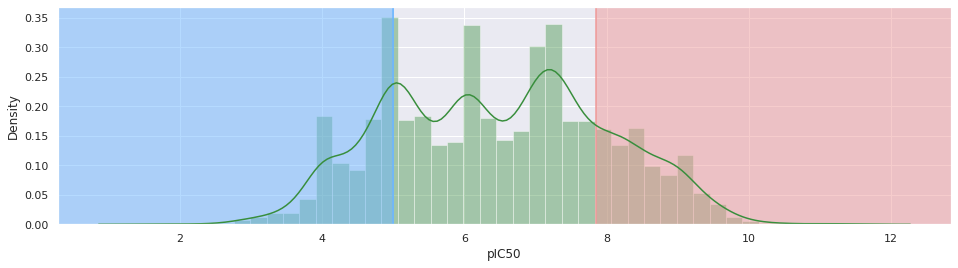

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16, 4))

#plotting the two lines
p1 = plt.axvline(x=botton_line,color='#6DB6FF')
p2 = plt.axvline(x=top_line,color='#EF9A9A')

#plotting the PDF
ax = sns.distplot(df_norm['pIC50'], hist=True, color='#388E3C')

xlim = ax.get_xlim()
ax.axvspan(xlim[0], botton_line, color='#6DB6FF', alpha=0.5)
ax.axvspan(top_line, xlim[1], color='#EF9A9A', alpha=0.5)
#reset xlim
ax.set_xlim(xlim)
plt.show()

## **Labeling**

In [27]:
bioactivity_threshold = []
for i in df_norm.pIC50:
  if float(i) >= top_line:
    bioactivity_threshold.append("active")
  elif float(i) <= botton_line:
    bioactivity_threshold.append("inactive")
  else:
    bioactivity_threshold.append("intermediate")

In [28]:
# Combine the data
bioactivity_class = pd.Series(bioactivity_threshold, name='bioactivity_class')
df7 = pd.concat([df_norm, bioactivity_class], axis=1)
print(df7.shape)
df7.head(5)

(8537, 4)


,molecule_chembl_id,canonical_smiles,pIC50,bioactivity_class
0,CHEMBL63786,Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1,11.522879,active
1,CHEMBL53711,CN(C)c1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.221849,active
2,CHEMBL35820,CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC,11.221849,active
3,CHEMBL53753,CNc1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.096910,active
4,CHEMBL66031,Brc1cccc(Nc2ncnc3cc4[nH]cnc4cc23)c1,11.096910,active


In [29]:
print(
    ' active',df7['bioactivity_class'][df7['bioactivity_class']=="active"].count(),'\n',
    'inactive',df7['bioactivity_class'][df7['bioactivity_class']=="inactive"].count(),'\n',
    'intermediate',df7['bioactivity_class'][df7['bioactivity_class']=="intermediate"].count()
)

 active 1715 
 inactive 1916 
 intermediate 4906


Saves dataframe to CSV file

In [30]:
df7.to_csv('CHEMBL203_bioactivity_data_curated.csv', index=False)

# **Removing 'intermediate' class**

In [33]:
df_2class = df7[df7['bioactivity_class'] != 'intermediate']
print(df_2class.shape)
df_2class.tail(3)

(3631, 4)


,molecule_chembl_id,canonical_smiles,pIC50,bioactivity_class
8534,CHEMBL76587,N#CC(C#N)Cc1ccc(O)cc1,2.187087,inactive
8535,CHEMBL490510,O=C(/C=C/c1ccc(O)c(O)c1)c1ccc(O[C@@H]2O[C@H](C...,1.721246,inactive
8536,CHEMBL45068,O=C(CCc1ccc(O)cc1)c1c(O)cc(O)cc1O,1.602060,inactive


In [34]:
df_2class.to_csv('CHEMBL203_2classes_data.csv', index=False)

# **Exporatory Data Analysis**

## **Install conda and rdkit**

In [36]:
# Install conda and rdkit
! wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
! chmod +x Miniconda3-py37_4.8.2-Linux-x86_64.sh
! bash ./Miniconda3-py37_4.8.2-Linux-x86_64.sh -b -f -p /usr/local
! conda install -c rdkit rdkit -y
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

--2021-04-08 18:33:29--  https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.131.3, 104.16.130.3, 2606:4700::6810:8203, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.131.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85055499 (81M) [application/x-sh]
Saving to: ‘Miniconda3-py37_4.8.2-Linux-x86_64.sh’

Miniconda3-py37_4.8 100%[===================>]  81.12M   133MB/s    in 0.6s    

2021-04-08 18:33:30 (133 MB/s) - ‘Miniconda3-py37_4.8.2-Linux-x86_64.sh’ saved [85055499/85055499]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: / - done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - _libgcc_mutex==0.1=main
    - asn1crypto==1.3.0=py37_0
    - ca-certificates==2020.1.1=0
    - certifi==2019.11.28=py37_0
    - cffi==1.14.0=py37h2e261b9_0
    - chardet==3.0.4=py37_1003
    - conda-package-handling==1.6.0=py37h

## **Lipinski 5-rule descriptors**


In [37]:
import pandas as pd

In [41]:
df = pd.read_csv('CHEMBL203_2classes_data.csv')
df.head(3)

,molecule_chembl_id,canonical_smiles,pIC50,bioactivity_class
0,CHEMBL63786,Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1,11.522879,active
1,CHEMBL53711,CN(C)c1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.221849,active
2,CHEMBL35820,CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC,11.221849,active


### **Import libraries**

In [42]:
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski

### **Calculate descriptors**

In [43]:
# Inspired by: https://codeocean.com/explore/capsules?query=tag:data-curation

def lipinski(smiles, verbose=False):

    moldata= []
    for elem in smiles:
        mol=Chem.MolFromSmiles(elem) 
        moldata.append(mol)
       
    baseData= np.arange(1,1)
    i=0  
    for mol in moldata:        
       
        desc_MolWt = Descriptors.MolWt(mol)
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_NumHDonors = Lipinski.NumHDonors(mol)
        desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)
           
        row = np.array([desc_MolWt,
                        desc_MolLogP,
                        desc_NumHDonors,
                        desc_NumHAcceptors])   
    
        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i=i+1      
    
    columnNames=["MW","LogP","NumHDonors","NumHAcceptors"]   
    descriptors = pd.DataFrame(data=baseData,columns=columnNames)
    
    return descriptors

In [44]:
df_lipinski = lipinski(df.canonical_smiles)
df_lipinski

,MW,LogP,NumHDonors,NumHAcceptors
0,350.219,5.28910,1.0,3.0
1,344.216,3.59690,1.0,5.0
2,388.265,4.93330,1.0,5.0
3,330.189,3.57260,2.0,5.0
4,340.184,4.01220,2.0,4.0
...,...,...,...,...
3626,164.160,1.49000,2.0,2.0
3627,404.836,5.20048,1.0,6.0
3628,172.187,1.59806,1.0,3.0
3629,450.396,-0.41620,8.0,11.0


In [45]:
df_combined = pd.concat([df,df_lipinski], axis=1)

df_combined

,molecule_chembl_id,canonical_smiles,pIC50,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors
0,CHEMBL63786,Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1,11.522879,active,350.219,5.28910,1.0,3.0
1,CHEMBL53711,CN(C)c1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.221849,active,344.216,3.59690,1.0,5.0
2,CHEMBL35820,CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC,11.221849,active,388.265,4.93330,1.0,5.0
3,CHEMBL53753,CNc1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.096910,active,330.189,3.57260,2.0,5.0
4,CHEMBL66031,Brc1cccc(Nc2ncnc3cc4[nH]cnc4cc23)c1,11.096910,active,340.184,4.01220,2.0,4.0
...,...,...,...,...,...,...,...,...
3626,CHEMBL66879,O=C(O)/C=C/c1ccc(O)cc1,2.522879,inactive,164.160,1.49000,2.0,2.0
3627,CHEMBL261238,CN(c1cccnc1)c1cc2c(Nc3ccc(F)c(Cl)c3)c(C#N)cnc2cn1,2.301030,inactive,404.836,5.20048,1.0,6.0
3628,CHEMBL76587,N#CC(C#N)Cc1ccc(O)cc1,2.187087,inactive,172.187,1.59806,1.0,3.0
3629,CHEMBL490510,O=C(/C=C/c1ccc(O)c(O)c1)c1ccc(O[C@@H]2O[C@H](C...,1.721246,inactive,450.396,-0.41620,8.0,11.0


In [46]:
df_combined.to_csv('CHEMBL203_2classes_lipinski_EDA_data.csv', index=False)

## **Chemical Space Analysis**

### **Import library**

In [47]:
import seaborn as sns
sns.set(style='ticks')
import matplotlib.pyplot as plt

**Statistical analysis | Mann-Whitney U Test**

In [48]:
def mannwhitney(descriptor, verbose=False):
  # https://machinelearningmastery.com/nonparametric-statistical-significance-tests-in-python/
  from numpy.random import seed
  from numpy.random import randn
  from scipy.stats import mannwhitneyu

# seed the random number generator
  seed(1)

# actives and inactives
  selection = [descriptor, 'bioactivity_class']
  df = df_combined[selection]
  active = df[df.bioactivity_class == 'active']
  active = active[descriptor]

  selection = [descriptor, 'bioactivity_class']
  df = df_combined[selection]
  inactive = df[df.bioactivity_class == 'inactive']
  inactive = inactive[descriptor]

# compare samples
  stat, p = mannwhitneyu(active, inactive)
  #print('Statistics=%.3f, p=%.3f' % (stat, p))

# interpret
  alpha = 0.05
  if p > alpha:
    interpretation = 'Same distribution (fail to reject H0)'
  else:
    interpretation = 'Different distribution (reject H0)'
  
  results = pd.DataFrame({'Descriptor':descriptor,
                          'Statistics':stat,
                          'p':p,
                          'alpha':alpha,
                          'Interpretation':interpretation}, index=[0])
  filename = 'CHEMBL203_EGFR_mannwhitneyu_' + descriptor + '.csv'
  results.to_csv(filename)

  return results

### **Scatter plot of MW versus LogP**



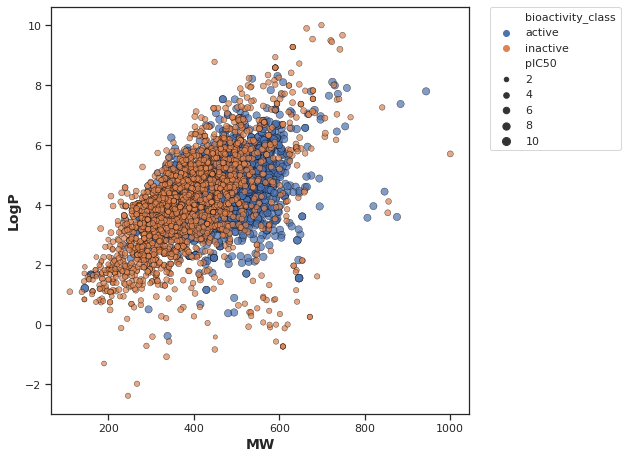

In [49]:
plt.figure(figsize=(7.5, 7.5))

sns.scatterplot(x='MW', y='LogP', data=df_combined, hue='bioactivity_class', size='pIC50', edgecolor='black', alpha=0.7)

plt.xlabel('MW', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.savefig('CHEMBL203_EGFR_plot_MW_vs_LogP.pdf')

### **Box plots &　Hypothesis Test**

#### **MW**

Text(0, 0.5, 'pIC50 value')

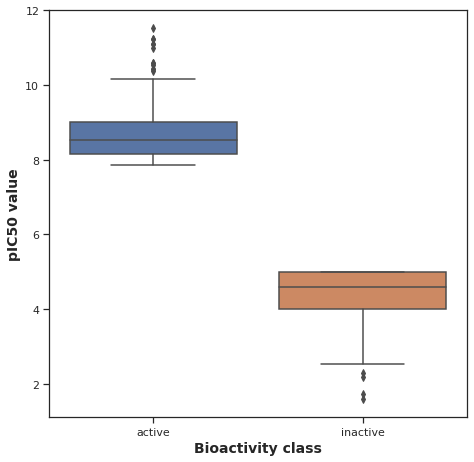

In [50]:
plt.figure(figsize=(7.5, 7.5))

sns.boxplot(x = 'bioactivity_class', y = 'pIC50', data = df_combined)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('pIC50 value', fontsize=14, fontweight='bold')

#plt.savefig('CHEMBL203_EGFR_plot_ic50.pdf')

In [51]:
mannwhitney('MW')

,Descriptor,Statistics,p,alpha,Interpretation
0,MW,938051.0,5.703709e-111,0.05,Different distribution (reject H0)


#### **LogP**

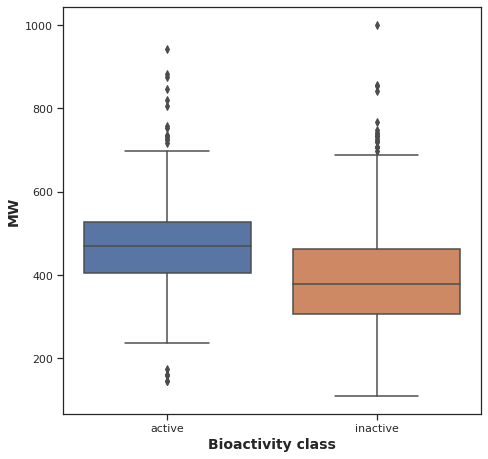

In [52]:
plt.figure(figsize=(7.5, 7.5))

sns.boxplot(x = 'bioactivity_class', y = 'MW', data = df_combined)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('MW', fontsize=14, fontweight='bold')

plt.savefig('CHEMBL203_EGFR_plot_MW.pdf')

#### **NumHDonors**

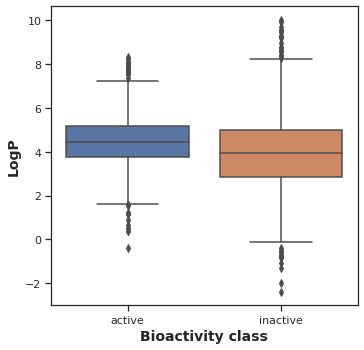

In [53]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'LogP', data = df_combined)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')

plt.savefig('CHEMBL203_EGFR_plot_LogP.pdf')

In [54]:
mannwhitney('NumHDonors')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHDonors,1388048.5,1.093037e-17,0.05,Different distribution (reject H0)


#### **NumHAcceptors**

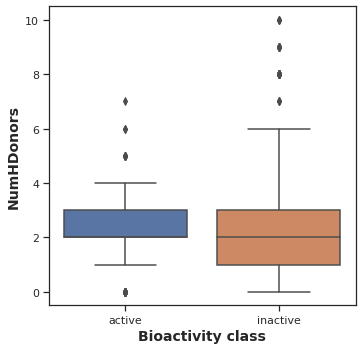

In [55]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'NumHDonors', data = df_combined)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHDonors', fontsize=14, fontweight='bold')

plt.savefig('CHEMBL203_EGFR_plot_NumHDonors.pdf')

In [56]:
mannwhitney('NumHAcceptors')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHAcceptors,1020190.5,7.555323e-89,0.05,Different distribution (reject H0)


# **Zip files**

In [57]:
! zip -r results.zip . -i *.csv *.pdf

  adding: CHEMBL203_2classes_lipinski_EDA_data.csv (deflated 77%)
  adding: CHEMBL203_bioactivity_data_preprocessed.csv (deflated 79%)
  adding: CHEMBL203_EGFR_plot_NumHDonors.pdf (deflated 38%)
  adding: CHEMBL203_EGFR_mannwhitneyu_NumHDonors.csv (deflated 11%)
  adding: raw_CHEMBL203_EGFR.csv (deflated 85%)
  adding: CHEMBL203_EGFR_mannwhitneyu_NumHAcceptors.csv (deflated 10%)
  adding: CHEMBL203_EGFR_mannwhitneyu_MW.csv (deflated 9%)
  adding: CHEMBL203_bioactivity_data_curated.csv (deflated 81%)
  adding: CHEMBL203_EGFR_plot_MW_vs_LogP.pdf (deflated 2%)
  adding: CHEMBL203_2classes_data.csv (deflated 80%)
  adding: CHEMBL203_EGFR_plot_LogP.pdf (deflated 37%)
  adding: CHEMBL203_EGFR_plot_MW.pdf (deflated 39%)


# **Calculate fingerprint descriptors**

## **Download PaDEL-Descriptor**

In [58]:
! wget http://www.yapcwsoft.com/dd/padeldescriptor/PaDEL-Descriptor.zip

--2021-04-08 18:35:37--  http://www.yapcwsoft.com/dd/padeldescriptor/PaDEL-Descriptor.zip
Resolving www.yapcwsoft.com (www.yapcwsoft.com)... 118.189.195.172
Connecting to www.yapcwsoft.com (www.yapcwsoft.com)|118.189.195.172|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20875190 (20M) [application/zip]
Saving to: ‘PaDEL-Descriptor.zip’

PaDEL-Descriptor.zi 100%[===================>]  19.91M  6.66MB/s    in 3.0s    

2021-04-08 18:35:40 (6.66 MB/s) - ‘PaDEL-Descriptor.zip’ saved [20875190/20875190]



In [59]:
! unzip PaDEL-Descriptor.zip

Archive:  PaDEL-Descriptor.zip
  inflating: Descriptors.xls         
  inflating: descriptors.xml         
   creating: lib/
  inflating: lib/ambit2-base-2.4.7-SNAPSHOT.jar  
  inflating: lib/ambit2-core-2.4.7-SNAPSHOT.jar  
  inflating: lib/ambit2-smarts-2.4.7-SNAPSHOT.jar  
  inflating: lib/appframework-1.0.3.jar  
  inflating: lib/cdk-1.4.15.jar      
  inflating: lib/commons-cli-1.2.jar  
  inflating: lib/guava-17.0.jar      
  inflating: lib/jama.jar            
  inflating: lib/jgrapht-0.6.0.jar   
  inflating: lib/l2fprod-common-all.jar  
  inflating: lib/libPaDEL-Descriptor.jar  
  inflating: lib/libPaDEL-Jobs.jar   
  inflating: lib/libPaDEL.jar        
  inflating: lib/swing-worker-1.1.jar  
  inflating: lib/vecmath1.2-1.14.jar  
  inflating: lib/xom-1.1.jar         
   creating: license/
  inflating: license/lgpl-2.1.txt    
  inflating: license/lgpl.license    
  inflating: license/LICENSE.txt     
  inflating: license/README - CDK    
  inflating: PaDEL-Descriptor.jar    


In [60]:
# Modify the descriptors.xml file for calculation
import lxml.etree

# input
doc = lxml.etree.parse('descriptors.xml')
# modification
for el in doc.xpath("//Descriptor[@name!='PubchemFingerprinter']"):
  el.attrib['value'] = 'false'
# output
# open('output_file.xml', 'w').write(lxml.etree.tostring(doc))
doc.write('pubchemfingerprinter.xml')

## **Load bioactivity data**

In [61]:
import pandas as pd

In [62]:
df = pd.read_csv('CHEMBL203_2classes_lipinski_EDA_data.csv')
df.head(3)

,molecule_chembl_id,canonical_smiles,pIC50,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors
0,CHEMBL63786,Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1,11.522879,active,350.219,5.2891,1.0,3.0
1,CHEMBL53711,CN(C)c1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.221849,active,344.216,3.5969,1.0,5.0
2,CHEMBL35820,CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC,11.221849,active,388.265,4.9333,1.0,5.0


In [63]:
selection = ['canonical_smiles','molecule_chembl_id']
df_selection = df[selection]
df_selection.to_csv('molecule.smi', sep='\t', index=False, header=False)

In [64]:
! cat molecule.smi | head -5

Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1	CHEMBL63786
CN(C)c1cc2c(Nc3cccc(Br)c3)ncnc2cn1	CHEMBL53711
CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC	CHEMBL35820
CNc1cc2c(Nc3cccc(Br)c3)ncnc2cn1	CHEMBL53753
Brc1cccc(Nc2ncnc3cc4[nH]cnc4cc23)c1	CHEMBL66031


In [65]:
! cat molecule.smi | wc -l

3631


## **Calculate PaDEL descriptors**

In [66]:
! java -Xms1G -Xmx1G -Djava.awt.headless=true -jar ./PaDEL-Descriptor.jar -removesalt -standardizenitro -fingerprints -descriptortypes ./pubchemfingerprinter.xml -dir ./ -file binary_descriptors_output.csv

Processing CHEMBL63786 in molecule.smi (1/3631). 
Processing CHEMBL53711 in molecule.smi (2/3631). 
Processing CHEMBL53753 in molecule.smi (4/3631). Average speed: 3.85 s/mol.
Processing CHEMBL35820 in molecule.smi (3/3631). Average speed: 7.02 s/mol.
Processing CHEMBL176582 in molecule.smi (6/3631). Average speed: 2.76 s/mol.
Processing CHEMBL66031 in molecule.smi (5/3631). Average speed: 2.67 s/mol.
Processing CHEMBL174426 in molecule.smi (8/3631). Average speed: 1.49 s/mol.
Processing CHEMBL29197 in molecule.smi (7/3631). Average speed: 1.75 s/mol.
Processing CHEMBL1243316 in molecule.smi (9/3631). Average speed: 1.35 s/mol.
Processing CHEMBL363815 in molecule.smi (10/3631). Average speed: 1.20 s/mol.
Processing CHEMBL3613702 in molecule.smi (11/3631). Average speed: 1.26 s/mol.
Processing CHEMBL275762 in molecule.smi (13/3631). Average speed: 0.97 s/mol.
Processing CHEMBL4521381 in molecule.smi (12/3631). Average speed: 1.03 s/mol.
Processing CHEMBL4103912 in molecule.smi (14/3631)

In [67]:
! ls -l

total 125272
-rw-r--r-- 1 root root  6465213 Apr  8 18:48 binary_descriptors_output.csv
-rw-r--r-- 1 root root   319035 Apr  8 18:33 CHEMBL203_2classes_data.csv
-rw-r--r-- 1 root root   474015 Apr  8 18:35 CHEMBL203_2classes_lipinski_EDA_data.csv
-rw-r--r-- 1 root root   809181 Apr  8 18:32 CHEMBL203_bioactivity_data_curated.csv
-rw-r--r-- 1 root root   637878 Apr  8 18:31 CHEMBL203_bioactivity_data_preprocessed.csv
-rw-r--r-- 1 root root      123 Apr  8 18:35 CHEMBL203_EGFR_mannwhitneyu_MW.csv
-rw-r--r-- 1 root root      134 Apr  8 18:35 CHEMBL203_EGFR_mannwhitneyu_NumHAcceptors.csv
-rw-r--r-- 1 root root      132 Apr  8 18:35 CHEMBL203_EGFR_mannwhitneyu_NumHDonors.csv
-rw-r--r-- 1 root root    14603 Apr  8 18:35 CHEMBL203_EGFR_plot_LogP.pdf
-rw-r--r-- 1 root root    13588 Apr  8 18:35 CHEMBL203_EGFR_plot_MW.pdf
-rw-r--r-- 1 root root   639570 Apr  8 18:35 CHEMBL203_EGFR_plot_MW_vs_LogP.pdf
-rw-r--r-- 1 root root    14824 Apr  8 18:35 CHEMBL203_EGFR_plot_NumHDonors.pdf
-rw-r--r-- 1 ro

# **Preparing the X and Y Data Matrices**

## **X data matrix**

In [68]:
df_X = pd.read_csv('binary_descriptors_output.csv')
df_X.head(5)

,Name,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,PubchemFP10,PubchemFP11,PubchemFP12,PubchemFP13,PubchemFP14,PubchemFP15,PubchemFP16,PubchemFP17,PubchemFP18,PubchemFP19,PubchemFP20,PubchemFP21,PubchemFP22,PubchemFP23,PubchemFP24,PubchemFP25,PubchemFP26,PubchemFP27,PubchemFP28,PubchemFP29,PubchemFP30,PubchemFP31,PubchemFP32,PubchemFP33,PubchemFP34,PubchemFP35,PubchemFP36,PubchemFP37,PubchemFP38,...,PubchemFP841,PubchemFP842,PubchemFP843,PubchemFP844,PubchemFP845,PubchemFP846,PubchemFP847,PubchemFP848,PubchemFP849,PubchemFP850,PubchemFP851,PubchemFP852,PubchemFP853,PubchemFP854,PubchemFP855,PubchemFP856,PubchemFP857,PubchemFP858,PubchemFP859,PubchemFP860,PubchemFP861,PubchemFP862,PubchemFP863,PubchemFP864,PubchemFP865,PubchemFP866,PubchemFP867,PubchemFP868,PubchemFP869,PubchemFP870,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,CHEMBL53711,1,1,0,0,0,0,0,0,0,1,1,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,CHEMBL63786,1,1,0,0,0,0,0,0,0,1,1,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,CHEMBL35820,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,CHEMBL53753,1,1,0,0,0,0,0,0,0,1,1,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,CHEMBL66031,1,1,0,0,0,0,0,0,0,1,1,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [69]:
df_X = df_X.drop(columns=['Name'])
print(df_X.shape)
df_X.head(3)

(3631, 881)


,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,PubchemFP10,PubchemFP11,PubchemFP12,PubchemFP13,PubchemFP14,PubchemFP15,PubchemFP16,PubchemFP17,PubchemFP18,PubchemFP19,PubchemFP20,PubchemFP21,PubchemFP22,PubchemFP23,PubchemFP24,PubchemFP25,PubchemFP26,PubchemFP27,PubchemFP28,PubchemFP29,PubchemFP30,PubchemFP31,PubchemFP32,PubchemFP33,PubchemFP34,PubchemFP35,PubchemFP36,PubchemFP37,PubchemFP38,PubchemFP39,...,PubchemFP841,PubchemFP842,PubchemFP843,PubchemFP844,PubchemFP845,PubchemFP846,PubchemFP847,PubchemFP848,PubchemFP849,PubchemFP850,PubchemFP851,PubchemFP852,PubchemFP853,PubchemFP854,PubchemFP855,PubchemFP856,PubchemFP857,PubchemFP858,PubchemFP859,PubchemFP860,PubchemFP861,PubchemFP862,PubchemFP863,PubchemFP864,PubchemFP865,PubchemFP866,PubchemFP867,PubchemFP868,PubchemFP869,PubchemFP870,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,1,1,0,0,0,0,0,0,0,1,1,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1,0,0,0,0,0,0,0,1,1,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## **Y variable**

In [70]:
df_Y = df['bioactivity_class']
df_Y.shape

(3631,)

## **Final dataset**

In [71]:
df_final = pd.concat([df_X,df_Y], axis=1)
print(df_final.shape)
df_final.head(3)

(3631, 882)


,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,PubchemFP10,PubchemFP11,PubchemFP12,PubchemFP13,PubchemFP14,PubchemFP15,PubchemFP16,PubchemFP17,PubchemFP18,PubchemFP19,PubchemFP20,PubchemFP21,PubchemFP22,PubchemFP23,PubchemFP24,PubchemFP25,PubchemFP26,PubchemFP27,PubchemFP28,PubchemFP29,PubchemFP30,PubchemFP31,PubchemFP32,PubchemFP33,PubchemFP34,PubchemFP35,PubchemFP36,PubchemFP37,PubchemFP38,PubchemFP39,...,PubchemFP842,PubchemFP843,PubchemFP844,PubchemFP845,PubchemFP846,PubchemFP847,PubchemFP848,PubchemFP849,PubchemFP850,PubchemFP851,PubchemFP852,PubchemFP853,PubchemFP854,PubchemFP855,PubchemFP856,PubchemFP857,PubchemFP858,PubchemFP859,PubchemFP860,PubchemFP861,PubchemFP862,PubchemFP863,PubchemFP864,PubchemFP865,PubchemFP866,PubchemFP867,PubchemFP868,PubchemFP869,PubchemFP870,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880,bioactivity_class
0,1,1,0,0,0,0,0,0,0,1,1,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,active
1,1,1,0,0,0,0,0,0,0,1,1,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,active
2,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,active


In [72]:
df_final.to_csv('CHEMBL203_EGFR_2class_pubchem_fp.csv', index=False)